# РГР 1


## 1. Подготовка данных

### Датасет
- `x=hours_studied`
- `y=exame_score`


In [8]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, pearsonr, shapiro, normaltest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("grandmaster07/student-exam-score-dataset-analysis")
print("Path to dataset files:", path)

df = pd.read_csv("/Users/danyarmarkin/.cache/kagglehub/datasets/grandmaster07/student-exam-score-dataset-analysis/versions/1/student_exam_scores.csv")

Path to dataset files: /Users/danyarmarkin/.cache/kagglehub/datasets/grandmaster07/student-exam-score-dataset-analysis/versions/1


In [9]:
# Просмотр структуры данных
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

Размер данных: (200, 6)

Первые 5 строк:
  student_id  hours_studied  sleep_hours  attendance_percent  previous_scores  \
0       S001            8.0          8.8                72.1               45   
1       S002            1.3          8.6                60.7               55   
2       S003            4.0          8.2                73.7               86   
3       S004            3.5          4.8                95.1               66   
4       S005            9.1          6.4                89.8               71   

   exam_score  
0        30.2  
1        25.0  
2        35.8  
3        34.0  
4        40.3  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   

In [20]:
x = df["hours_studied"]
y = df["exam_score"]

n = len(x)

print(f"Размер набора данных: {n}")

Размер набора данных: 200


## 2. Построение и анализ корреляционного поля

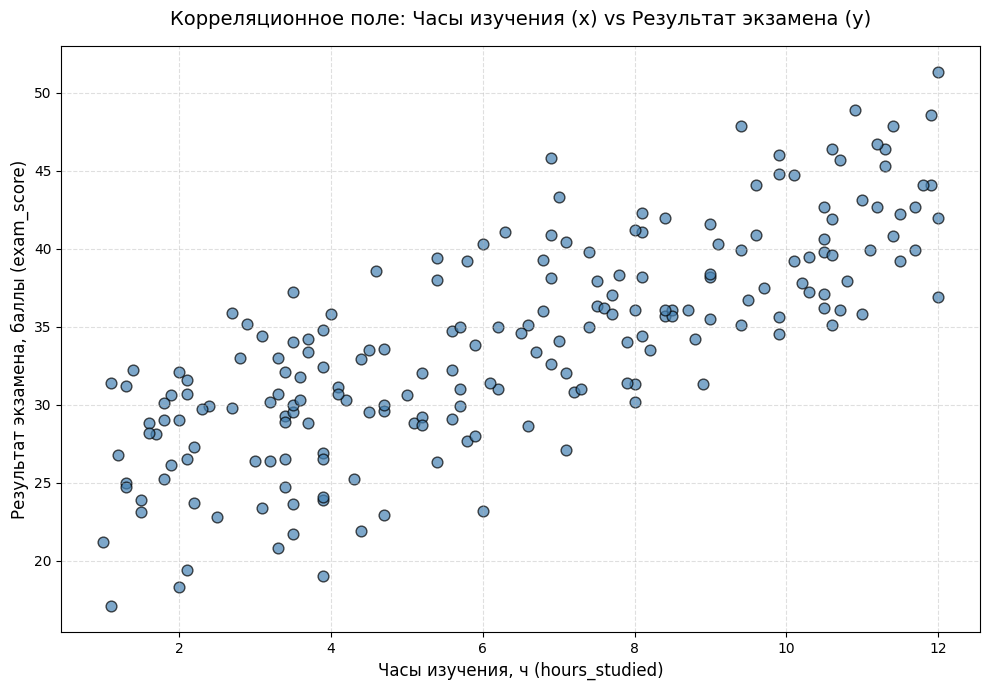

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.7, color='steelblue', edgecolors='k', s=60)
plt.title('Корреляционное поле: Часы изучения (x) vs Результат экзамена (y)', fontsize=14, pad=15)
plt.xlabel('Часы изучения, ч (hours_studied)', fontsize=12)
plt.ylabel('Результат экзамена, баллы (exam_score)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Вывод
Исходя из графика выдвигаем гипотезу о линейности связи между `x` и `y`

## 3. Анализ связи между переменными

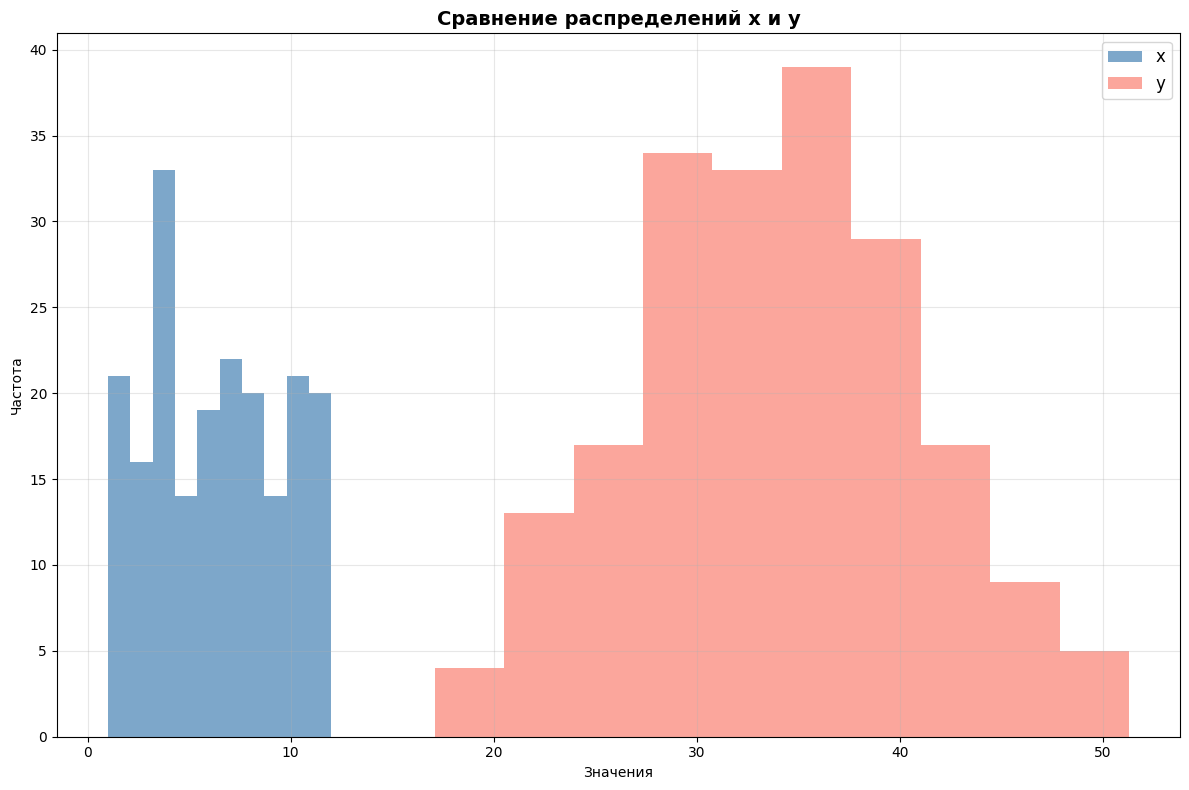

In [99]:
plt.figure(figsize=(12, 8))
plt.hist(x, color='steelblue', alpha=0.7, label='x')
plt.hist(y, color='salmon', alpha=0.7, label='y')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Сравнение распределений x и y', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [71]:
def test_normality(data, name):
    print(f"\nТесты на нормальность для {name}:")
    shapiro_stat, shapiro_p = shapiro(data)
    print(f"Shapiro-Wilk: статистика = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")
    alpha = 0.05
    if shapiro_p > alpha:
        print("Гипотеза о нормальности НЕ отвергается")
    else:
        print("Гипотеза о нормальности ОТВЕРГАЕТСЯ")

test_normality(x, "x (hours_studied)")

test_normality(y, "y (exam_score)")


Тесты на нормальность для x (hours_studied):
Shapiro-Wilk: статистика = 0.9489, p-value = 1.4877e-06
Гипотеза о нормальности ОТВЕРГАЕТСЯ

Тесты на нормальность для y (exam_score):
Shapiro-Wilk: статистика = 0.9957, p-value = 8.4082e-01
Гипотеза о нормальности НЕ отвергается


In [72]:
# Коэффициент корреляции Пирсона
r, p_value = pearsonr(x, y)

print(f"Коэффициент корреляции Пирсона:")
print(f"r = {r:.4f}")
print(f"p-value = {p_value:.4e}")

# Проверка надёжности
alpha = 0.05
if p_value < alpha:
    print(f"Связь статистически значима")
else:
    print(f"Связь статистически НЕ значима")

Коэффициент корреляции Пирсона:
r = 0.7768
p-value = 1.2720e-41
Связь статистически значима


In [73]:
z_r = np.arctanh(r)  # Fisher z-transform
se_z = 1 / np.sqrt(n - 3)

z_alpha = stats.norm.ppf(0.975)
ci_z_lower = z_r - z_alpha * se_z
ci_z_upper = z_r + z_alpha * se_z

ci_r_lower = np.tanh(ci_z_lower)
ci_r_upper = np.tanh(ci_z_upper)

print(f"95% доверительный интервал для r:")
print(f"[{ci_r_lower:.4f}; {ci_r_upper:.4f}]")

95% доверительный интервал для r:
[0.7151; 0.8264]


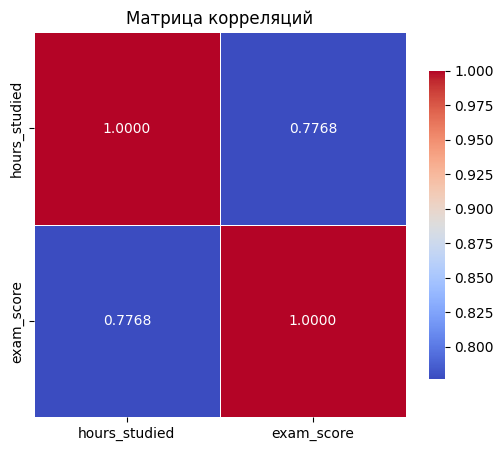

Коэффициент детерминации R² = 0.6033


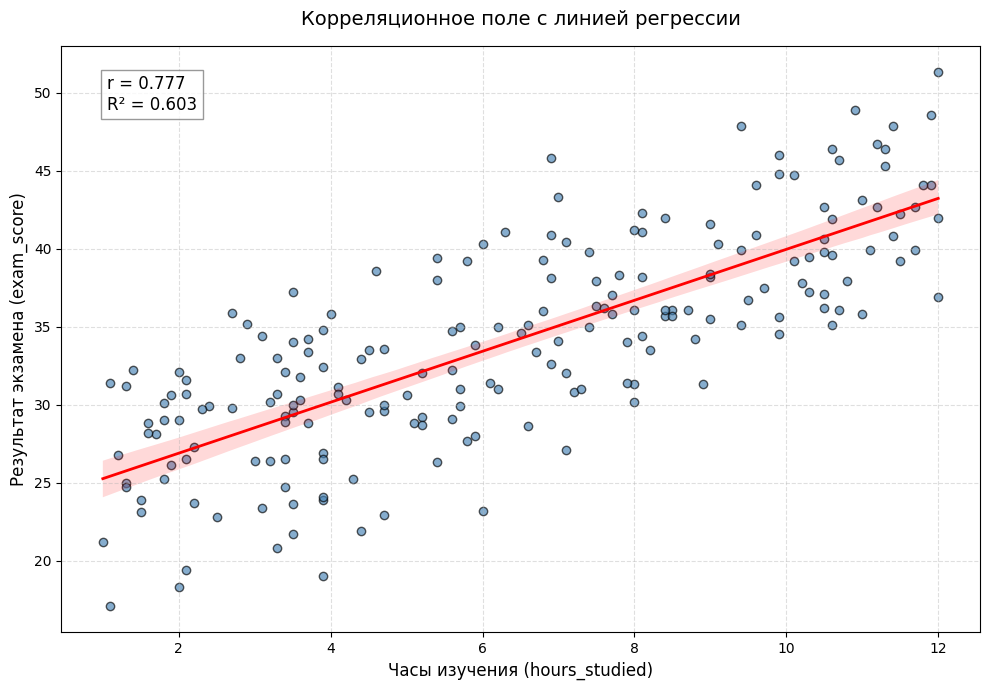

In [74]:
import seaborn as sns

# Импорт для линейной регрессии (если не импортировано ранее)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Корреляционная матрица (тепловая карта) — без изменений
corr_matrix = df[['hours_studied', 'exam_score']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций')
plt.show()

# --- Корреляционное поле с линией регрессии + R² ---
# Линейная модель для получения R²
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
y_pred = model.predict(x.values.reshape(-1, 1))

# Коэффициент детерминации R²
R2 = r2_score(y, y_pred)  # или r**2, где r — из pearsonr

print(f"Коэффициент детерминации R² = {R2:.4f}")

# График
plt.figure(figsize=(10, 7))
sns.regplot(
    x=x, y=y,
    scatter_kws={'alpha': 0.65, 'color': 'steelblue', 'edgecolor': 'k'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Добавляем текст с r и R² на график
plt.text(
    x=0.05, y=0.95,
    s=f'r = {r:.3f}\nR² = {R2:.3f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
    verticalalignment='top'
)

plt.title('Корреляционное поле с линией регрессии', fontsize=14, pad=15)
plt.xlabel('Часы изучения (hours_studied)', fontsize=12)
plt.ylabel('Результат экзамена (exam_score)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Вывод
Таким образом получаем вероятно линейную зависимость `y` от `x`, коэффициент корреляции статистически значим (доверительный интервал `[0.7151; 0.8264]`)

## 4. Оценка коэффициентов модели линейной регрессии

In [75]:

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
beta_0 = model.params[0]
beta_1 = model.params[1]

print(f"Уравнение регрессии:")
print(f"y = {beta_0:.4f} + {beta_1:.4f} * x")

print(model.summary())

Уравнение регрессии:
y = 23.6184 + 1.6341 * x
                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     301.2
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.27e-41
Time:                        03:00:07   Log-Likelihood:                -573.90
No. Observations:                 200   AIC:                             1152.
Df Residuals:                     198   BIC:                             1158.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


In [77]:
F_stat = model.fvalue
F_pvalue = model.f_pvalue

print(f"F-тест значимости уравнения регрессии:")
print(f"F = {F_stat:.4f}, p-value = {F_pvalue:.4e}")

t_beta0 = model.tvalues[0]
p_beta0 = model.pvalues[0]
t_beta1 = model.tvalues[1]
p_beta1 = model.pvalues[1]

print(f"\nt-тест для beta0")
print(f"t = {t_beta0:.4f}, p-value = {p_beta0:.4e}")

print(f"t-тест для beta1:")
print(f"t = {t_beta1:.4f}, p-value = {p_beta1:.4e}")

alpha = 0.05
if F_pvalue < alpha:
    print("Уравнение регрессии значимо в целом")
else:
    print("Уравнение НЕ значимо")

F-тест значимости уравнения регрессии:
F = 301.1716, p-value = 1.2720e-41

t-тест для beta0
t = 35.3401, p-value = 1.8642e-87
t-тест для beta1:
t = 17.3543, p-value = 1.2720e-41
Уравнение регрессии значимо в целом


In [100]:
y_pred = model.predict(X)
mean_ape = np.mean(np.abs((y - y_pred) / y) * 100)

print(f"MAPE = {mean_ape:.2f}%")

MAPE = 11.02%


In [79]:
x_mean = x.mean()
y_mean = y.mean()
elasticity_mean = beta_1 * (x_mean / y_mean)

print(f"E = {elasticity_mean:.4f}")

E = 0.3044


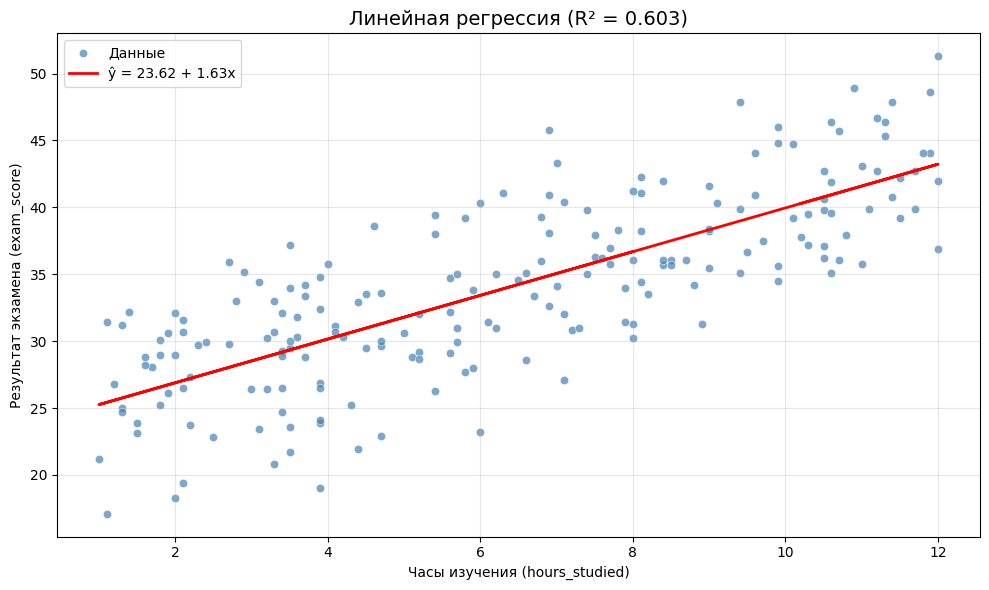

In [101]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, alpha=0.7, color='steelblue', label='Данные')
plt.plot(x, y_pred, color='red', linewidth=2, label=f'ŷ = {beta_0:.2f} + {beta_1:.2f}x')

plt.title(f'Линейная регрессия (R² = {R2:.3f})', fontsize=14)
plt.xlabel('Часы изучения (hours_studied)')
plt.ylabel('Результат экзамена (exam_score)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Анализ остатков

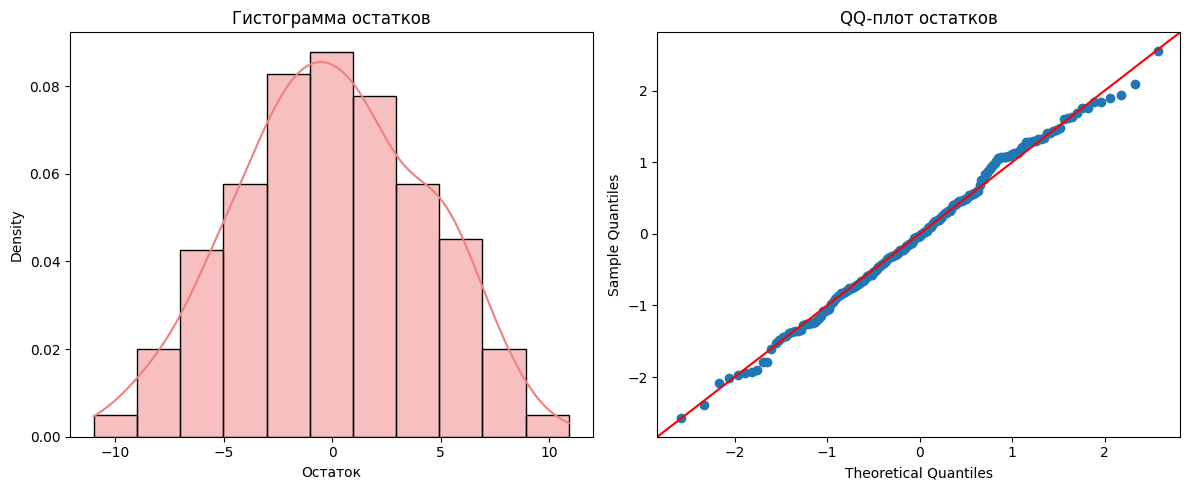

Тесты на нормальность остатков:
Shapiro-Wilk: W = 0.9935, p-value = 5.2311e-01
Нормальность остатков НЕ отвергается


In [53]:
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
residuals = model.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuals, kde=True, stat="density", color='lightcoral', ax=axes[0])
axes[0].set_title('Гистограмма остатков')
axes[0].set_xlabel('Остаток')

# QQ-плот
sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('QQ-плот остатков')

plt.tight_layout()
plt.show()

# Формальные тесты
print("Тесты на нормальность остатков:")
shapiro_stat, shapiro_p = shapiro(residuals)

print(f"Shapiro-Wilk: W = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")

alpha = 0.05
if shapiro_p > alpha:
    print("Нормальность остатков НЕ отвергается")
else:
    print("Нормальность остатков ОТВЕРГАЕТСЯ")

In [81]:
# Тест Дарбина-Уотсона
dw_stat = durbin_watson(residuals)

print(f"Тест Дарбина-Уотсона:")
print(f"DW = {dw_stat:.4f}")

if dw_stat < 1.5:
    print("Признаки положительной автокорреляции")
elif 1.5 <= dw_stat <= 2.5:
    print("Автокорреляция отсутствует")
else:
    print("Признаки отрицательной автокорреляции")

Тест Дарбина-Уотсона:
DW = 2.1036
Автокорреляция отсутствует


In [102]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Тест Голдфельда-Кванта
gq_stat, gq_pvalue, ordering = het_goldfeldquandt(residuals, x.values.reshape(-1, 1) )

print(f"Тест Голдфельда-Кванта:")
print(f"F-статистика = {gq_stat:.4f}")
print(f"p-value = {gq_pvalue:.4e}")

if gq_pvalue > 0.05:
    print("⇒ Гетероскедастичности возможно нет")
else:
    print("⇒ Гетероскедастичность точно есть")

Тест Голдфельда-Кванта:
F-статистика = 1.1892
p-value = 1.9512e-01
⇒ Гетероскедастичности возможно нет


In [103]:
conditions = {
    "Условие": [
        "Нормальность остатков",
        "Отсутствие автокорреляции",
        "Отсутствие гетероскедастичности"
    ],
    "Результат": [
        f"p_SW = {shapiro_p:.2e} -> {'T' if shapiro_p > 0.05 else 'F'}",
        f"DW = {dw_stat:.3f} -> {'T' if 1.5 <= dw_stat <= 2.5 else 'F'}",
        f"p = {gq_pvalue:.2e} -> {'T' if gq_pvalue > 0.05 else 'F'}"
    ]
}
pd.DataFrame(conditions)

,Условие,Результат
0,Нормальность остатков,p_SW = 5.23e-01 -> T
1,Отсутствие автокорреляции,DW = 2.104 -> T
2,Отсутствие гетероскедастичности,p = 1.95e-01 -> T


## 6. Построение альтернативных моделей
1. Логарифмическая (апочемубынет)
2. Квадратическая

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Добавляем константу
X_const = sm.add_constant(x)

# Функция для оценки модели и метрик
def fit_model(X, name):
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    aic = model.aic
    bic = model.bic
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    print(f"\n=== {name} ===")
    print(model.summary().tables[1])  # Коэффициенты
    print(f"R² = {r2:.4f}, R²_adj = {r2_adj:.4f}")
    print(f"AIC = {aic:.2f}, BIC = {bic:.2f}")
    print(f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, MAPE = {mape:.2f}%")

    return model, y_pred, {'R2': r2, 'R2_adj': r2_adj, 'AIC': aic, 'BIC': bic, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [86]:
X_lin = X_const.copy()
lin_model, lin_pred, lin_metrics = fit_model(X_lin, "1. Линейная")


=== 1. Линейная ===
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.6184      0.668     35.340      0.000      22.301      24.936
hours_studied     1.6341      0.094     17.354      0.000       1.448       1.820
R² = 0.6033, R²_adj = 0.6013
AIC = 1151.79, BIC = 1158.39
MAE = 3.478, RMSE = 4.265, MAPE = 11.02%


In [87]:
# Избегаем ln(0): x ≥ 1 → ок
X_log = sm.add_constant(np.log(x))
log_model, log_pred, log_metrics = fit_model(X_log, "2. Логарифмическая")


=== 2. Логарифмическая ===
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.7424      0.931     22.284      0.000      18.907      22.578
hours_studied     7.8815      0.520     15.163      0.000       6.856       8.906
R² = 0.5373, R²_adj = 0.5350
AIC = 1182.59, BIC = 1189.19
MAE = 3.712, RMSE = 4.607, MAPE = 11.77%


In [88]:
X_quad = sm.add_constant(pd.DataFrame({'x': x, 'x2': x**2}))
quad_model, quad_pred, quad_metrics = fit_model(X_quad, "3. Квадратичная")


=== 3. Квадратичная ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.7116      1.260     19.616      0.000      22.227      27.196
x              1.1894      0.445      2.675      0.008       0.313       2.066
x2             0.0341      0.033      1.024      0.307      -0.032       0.100
R² = 0.6054, R²_adj = 0.6014
AIC = 1152.73, BIC = 1162.62
MAE = 3.465, RMSE = 4.254, MAPE = 10.98%


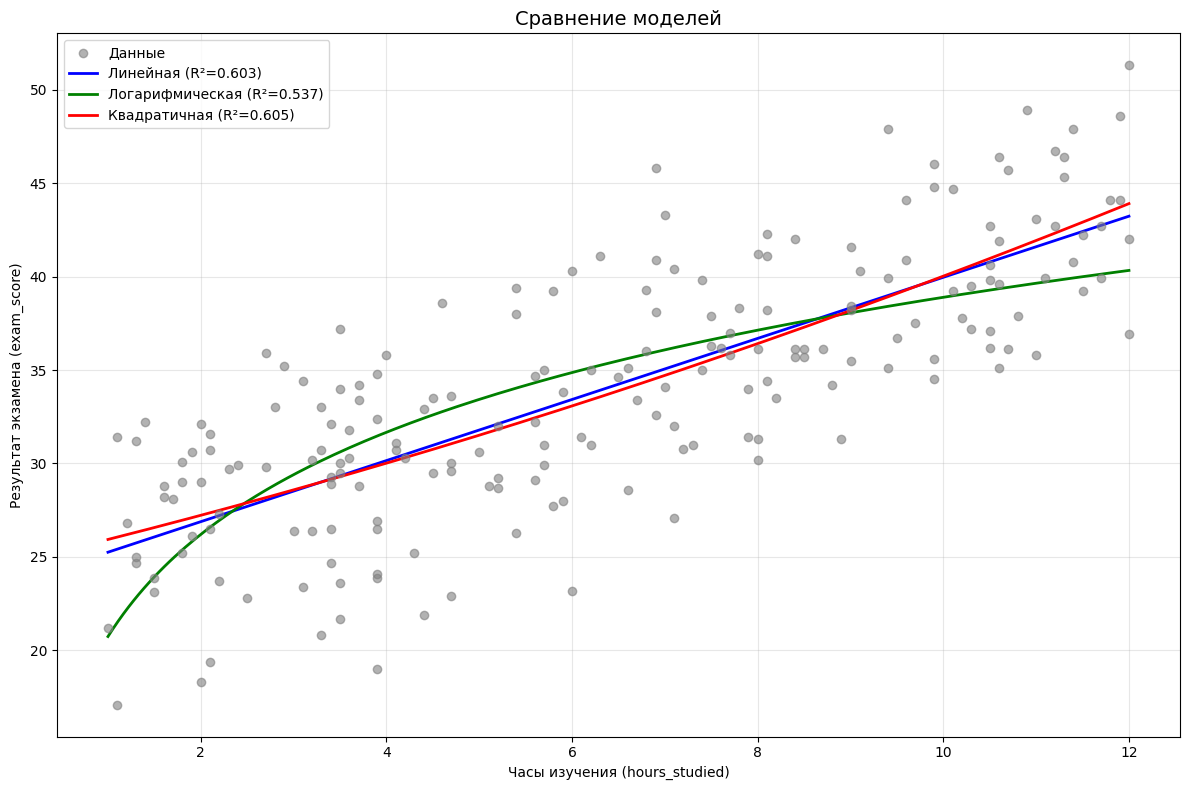

In [89]:
x_sort = np.linspace(x.min(), x.max(), 200)
plt.figure(figsize=(12, 8))

plt.scatter(x, y, alpha=0.6, color='gray', label='Данные', zorder=5)
plt.plot(x_sort, lin_model.predict(sm.add_constant(x_sort)),
         color='blue', linewidth=2, label=f'Линейная (R²={lin_metrics["R2"]:.3f})')
plt.plot(x_sort, log_model.predict(sm.add_constant(np.log(x_sort))),
         color='green', linewidth=2, label=f'Логарифмическая (R²={log_metrics["R2"]:.3f})')
X_quad_sort = sm.add_constant(pd.DataFrame({'const':1, 'x': x_sort, 'x2': x_sort**2}))
plt.plot(x_sort, quad_model.predict(X_quad_sort),
         color='red', linewidth=2, label=f'Квадратичная (R²={quad_metrics["R2"]:.3f})')

plt.title('Сравнение моделей', fontsize=14)
plt.xlabel('Часы изучения (hours_studied)')
plt.ylabel('Результат экзамена (exam_score)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
comparison = pd.DataFrame({
    'Модель': ['Линейная', 'Логарифмическая', 'Квадратичная'],
    'R²': [lin_metrics['R2'], log_metrics['R2'], quad_metrics['R2']],
    'R²_adj': [lin_metrics['R2_adj'], log_metrics['R2_adj'], quad_metrics['R2_adj']],
    'MAPE (%)': [lin_metrics['MAPE'], log_metrics['MAPE'], quad_metrics['MAPE']],
})

comparison = comparison.round(4)
comparison = comparison.sort_values(by='R²_adj', ascending=False)
print("Сравнение моделей:")
display(comparison)

Сравнение моделей:


,Модель,R²,R²_adj,MAPE (%)
2,Квадратичная,0.6054,0.6014,10.9766
0,Линейная,0.6033,0.6013,11.0162
1,Логарифмическая,0.5373,0.5350,11.7739


## 7. Выводы

В результате исследования можно сделать вывод о том, что результат экзамена имеет линейную связь с количеством часов подготовки

**Полученное линейное уравнение:**

`y = 23.6184 + 1.6341 * x`

Гипотеза подтверждена